In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle as pkl

In [90]:
amino_acids = ['CYS', 'VAL', 'LEU', 'MET', 'ASN', 'GLN', 'THR', 'SER', 'TYR', 'PHE', 'TRP', 'HIS', 'ILE'] #['ALA', 'CYS', 'VAL', 'LEU', 'ILE', 'MET', 'ASN', 'GLN', 'THR', 'SER', 'TYR', 'PHE', 'TRP', 'HIS']
ffmods = ['Unmodified', 'PW']
T = 300
R = 8.314*(10.0**(-3))
recalculate = True

In [91]:
expt_deltaGs = {
    'LEU':22,
    'ILE':22,
    'VAL':17,
    'MET':10,
    'CYS':5,
    'SER':-14,
    'THR':-11,
    'ASN':-28,
    'GLN':-25,
    'HIS':-20,
    'PHE':17,
    'TYR':-2,
    'TRP':9
}

In [92]:
deltaG_Martini3_paper = {
    'VAL':10.8,
    'LEU':11.4,
    'ILE':11.4,
    'MET':11.3,
    'ASN':-18.4,
    'GLN':-16.9,
    'THR':-10.7,
    'SER':-11.7,
    'CYS':4.3
}

In [93]:
#Functions for saving and loading pickle files
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

0.5950413223140496 0.4049586776859504


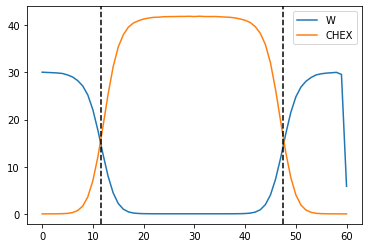

In [94]:
#Get CHEX and W volume fractions
CHEX_density_z = load_pickle('data/CHEX_density_z_SER_Unmodified.pkl')
W_density_z = load_pickle('data/W_density_z_SER_Unmodified.pkl')

CHEX_density_z_avg = np.average(CHEX_density_z['density'], axis=0)
W_density_z_avg = np.average(W_density_z['density'], axis=0)
z = CHEX_density_z['z']

idx_CHEX = np.where(CHEX_density_z_avg>W_density_z_avg)[0]
idx_CHEX_start = idx_CHEX[0]-1
idx_CHEX_end = idx_CHEX[-1]

CHEX_vol_fraction = (z[idx_CHEX_end] - z[idx_CHEX_start])/z[-1]
W_vol_fraction = 1.0-CHEX_vol_fraction
print(CHEX_vol_fraction, W_vol_fraction)

plt.plot(W_density_z_avg, label='W')
plt.plot(CHEX_density_z_avg, label='CHEX')
plt.axvline(z[idx_CHEX_start], c='black', ls='--')
plt.axvline(z[idx_CHEX_end], c='black', ls='--')
plt.legend()

In [95]:
if recalculate == True:
    partitioning_deltaGs = {}

    for aa in amino_acids:
        for ffmod in ffmods:

            print(aa, ffmod)

            time_CHEX, contacts_CHEX = np.genfromtxt(f'data/numcont_{aa}_{ffmod}_CHEX.xvg', skip_header=24, usecols=(0,1), unpack=True)
            contacts_CHEX*=0.5
            time_W, contacts_W = np.genfromtxt(f'data/numcont_{aa}_{ffmod}_W.xvg', skip_header=24, usecols=(0,1), unpack=True)

            n_frames_W = np.sum(contacts_W > contacts_CHEX) 
            n_frames_CHEX = np.sum(contacts_W < contacts_CHEX) 
            n_frames_trans = np.sum(contacts_W == contacts_CHEX)
            assert n_frames_W + n_frames_CHEX + n_frames_trans == len(contacts_CHEX)
            assert n_frames_W + n_frames_CHEX + n_frames_trans == len(contacts_W)

            deltaG = R*T*np.log((n_frames_CHEX/CHEX_vol_fraction)/(n_frames_W/W_vol_fraction))

            partitioning_deltaGs[f'{aa}_{ffmod}'] = deltaG

    save_pickle('partitioning_deltaGs.pkl', partitioning_deltaGs)

CYS Unmodified
CYS PW
VAL Unmodified
VAL PW
LEU Unmodified
LEU PW
MET Unmodified
MET PW
ASN Unmodified
ASN PW
GLN Unmodified
GLN PW
THR Unmodified
THR PW
SER Unmodified
SER PW
TYR Unmodified
TYR PW
PHE Unmodified
PHE PW
TRP Unmodified
TRP PW
HIS Unmodified
HIS PW
ILE Unmodified
ILE PW


In [96]:
partitioning_deltaGs = load_pickle('partitioning_deltaGs.pkl')

deltaG_Unmodified_vs_aa = []
deltaG_PW_vs_aa = []
deltaG_expt_vs_aa = []
deltaG_Unmodified_vs_aa_Martini3_paper = []
deltaG_Martini3_paper_vs_aa_Martini3_paper = []
deltaG_expt_vs_aa_Martini3_paper = []

for aa in amino_acids:
    deltaG_Unmodified_vs_aa.append(partitioning_deltaGs[f'{aa}_Unmodified'])
    deltaG_PW_vs_aa.append(partitioning_deltaGs[f'{aa}_PW'])
    deltaG_expt_vs_aa.append(expt_deltaGs[aa])
    
    if aa in deltaG_Martini3_paper.keys():
        deltaG_Unmodified_vs_aa_Martini3_paper.append(partitioning_deltaGs[f'{aa}_Unmodified'])
        deltaG_Martini3_paper_vs_aa_Martini3_paper.append(deltaG_Martini3_paper[aa])
        deltaG_expt_vs_aa_Martini3_paper.append(expt_deltaGs[aa])
        
deltaG_Unmodified_vs_aa = np.array(deltaG_Unmodified_vs_aa)
deltaG_PW_vs_aa = np.array(deltaG_PW_vs_aa)
deltaG_expt_vs_aa = np.array(deltaG_expt_vs_aa)
deltaG_Unmodified_vs_aa_Martini3_paper = np.array(deltaG_Unmodified_vs_aa_Martini3_paper)
deltaG_Martini3_paper_vs_aa_Martini3_paper = np.array(deltaG_Martini3_paper_vs_aa_Martini3_paper)
deltaG_expt_vs_aa_Martini3_paper = np.array(deltaG_expt_vs_aa_Martini3_paper)

In [97]:
def pearsonoutput(x,y):
    return stats.pearsonr(x,y)[0]

pearson_Unmodified, pval_pearson = stats.pearsonr(deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa)
bootstrap_result = stats.bootstrap((deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa), pearsonoutput, vectorized=False, paired=True)    
pearson_err_Unmodified = bootstrap_result.standard_error

pearson_PW, pval_pearson = stats.pearsonr(deltaG_expt_vs_aa, deltaG_PW_vs_aa)
bootstrap_result = stats.bootstrap((deltaG_expt_vs_aa, deltaG_PW_vs_aa), pearsonoutput, vectorized=False, paired=True)    
pearson_err_PW = bootstrap_result.standard_error

print(pearson_Unmodified, pearson_err_Unmodified)
print(pearson_PW, pearson_err_PW)

0.9409693450964485 0.030867907385511584
0.9485515200065427 0.02703689149505027


In [98]:
def rmsdoutput(expt_data, sim_data):
    return np.sqrt(np.average(np.square(sim_data-expt_data)))

rmsd_Unmodified = rmsdoutput(deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa)
bootstrap_result = stats.bootstrap((deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa), rmsdoutput, vectorized=False, paired=True)    
rmsd_err_Unmodified = bootstrap_result.standard_error

rmsd_PW = rmsdoutput(deltaG_expt_vs_aa, deltaG_PW_vs_aa)
bootstrap_result = stats.bootstrap((deltaG_expt_vs_aa, deltaG_PW_vs_aa), rmsdoutput, vectorized=False, paired=True)    
rmsd_err_PW = bootstrap_result.standard_error

print(rmsd_Unmodified, rmsd_err_Unmodified)
print(rmsd_PW, rmsd_err_PW)

11.59290652246057 1.394309183459063
11.26232933894011 1.3955190105368434


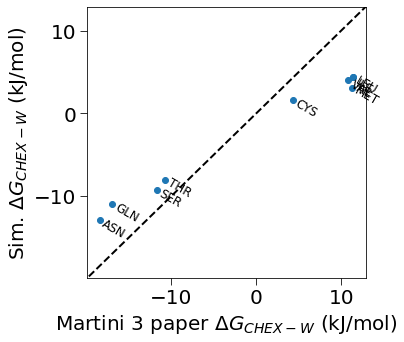

In [104]:
#Check with single beads from Martini 3 paper
fig = plt.figure(figsize=(5,5))

plt.plot(deltaG_Martini3_paper_vs_aa_Martini3_paper, deltaG_Unmodified_vs_aa_Martini3_paper, 'o')

i=0
for aa in amino_acids:
    if aa in deltaG_Martini3_paper.keys():
        plt.text(deltaG_Martini3_paper_vs_aa_Martini3_paper[i]+0.01, deltaG_Unmodified_vs_aa_Martini3_paper[i]-2.0, aa, fontsize=12, rotation=-30)
        i+=1
plt.plot([-100,100],[-100,100],'--',linewidth=2,color='black')

axis_max = np.amax(np.concatenate((deltaG_Unmodified_vs_aa_Martini3_paper, deltaG_Martini3_paper_vs_aa_Martini3_paper)))
axis_min = np.amin(np.concatenate((deltaG_Unmodified_vs_aa_Martini3_paper, deltaG_Martini3_paper_vs_aa_Martini3_paper)))
plt.xlim(axis_min-1.5, axis_max+1.5)
plt.ylim(axis_min-1.5, axis_max+1.5)

plt.xlabel('Martini 3 paper $\Delta G_{CHEX-W}$ (kJ/mol)', fontsize=20)
plt.ylabel('Sim. $\Delta G_{CHEX-W}$ (kJ/mol)', fontsize=20)
plt.tick_params(color='black', direction='out', length=7, labelsize=20)

fig.savefig("../figures/partitioning_dGsim_vs_Martini3paper.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("../figures/partitioning_dGsim_vs_Martini3paper.png", bbox_inches='tight', pad_inches=1, dpi=400)

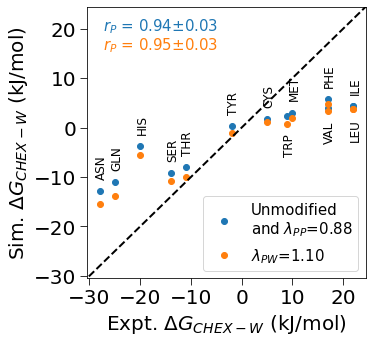

In [105]:
#Plot comparison with experimental deltaG

colors_pltdefault = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(figsize=(5,5))

plt.plot(deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa, 'o', label='Unmodified\nand $λ_{{PP}}$=0.88', c=colors_pltdefault[0])
plt.plot(deltaG_expt_vs_aa, deltaG_PW_vs_aa, 'o', label='$λ_{{PW}}$=1.10', c=colors_pltdefault[1])
#plt.plot(deltaG_expt_vs_aa_Martini3_paper, deltaG_Martini3_paper_vs_aa_Martini3_paper, 'o', c='green')

for i,aa in enumerate(amino_acids):
    
    if aa in ['TRP', 'VAL', 'LEU']:
        plt.text(deltaG_expt_vs_aa[i]-0.9, deltaG_PW_vs_aa[i]-6.0, aa, fontsize=12, rotation=90)
    else:
        plt.text(deltaG_expt_vs_aa[i]-0.9, deltaG_Unmodified_vs_aa[i]+3.0, aa, fontsize=12, rotation=90)
    #plt.text(deltaG_expt_vs_aa[i]+0.05, #deltaG_PW_vs_aa[i]-3.0, aa, fontsize=12, rotation=-30)
    
plt.plot([-100,100],[-100,100],'--',linewidth=2,color='black')

axis_max = np.amax(np.concatenate((deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa, deltaG_PW_vs_aa)))
axis_min = np.amin(np.concatenate((deltaG_expt_vs_aa, deltaG_Unmodified_vs_aa, deltaG_PW_vs_aa)))
plt.xlim(axis_min-2.5, axis_max+2.5)
plt.ylim(axis_min-2.5, axis_max+2.5)

plt.legend(fontsize=15, loc='lower right')
plt.text(0.17, 0.76, f'$r_{{P}}$ = {pearson_Unmodified:.2f}±{pearson_err_Unmodified:.2f}\n', fontsize=15, c=colors_pltdefault[0], transform=fig.transFigure)
plt.text(0.17, 0.76, f'$r_{{P}}$ = {pearson_PW:.2f}±{pearson_err_PW:.2f}', fontsize=15, c=colors_pltdefault[1], transform=fig.transFigure)

plt.xticks(np.arange(-30, 25, 10))
plt.yticks(np.arange(-30, 25, 10))

plt.xlabel('Expt. $\Delta G_{CHEX-W}$ (kJ/mol)', fontsize=20)
plt.ylabel('Sim. $\Delta G_{CHEX-W}$ (kJ/mol)', fontsize=20)
plt.tick_params(color='black', direction='out', length=7, labelsize=20)

fig.savefig("../figures/partitioning_dGsim_vs_exp.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig("../figures/partitioning_dGsim_vs_exp.png", bbox_inches='tight', pad_inches=1, dpi=400)